In [1]:
import psi4
import numpy as np
import scipy.linalg as sp
psi4.set_output_file("output.dat", True)  # setting output file
psi4.set_memory(int(40e8))
numpy_memory = 8
psi4.set_options({'basis': 'cc-pvdz', 'reference': 'uhf', 'scf_type': 'df'})


class Molecule:
    def __init__(self, geom_file):
        """
        sets up the molecule object
        
        input:
        geom_file: a link to a pubchem file    
            
        note:
        This class is designed to work in an iterative Restricted Closed Shell HF calculation. The guess matrix needs to be
        updated asap. This will always correspond to the curren fock-matrix.
        """
        if """pubchem""" in geom_file:
            self.id = psi4.geometry(geom_file)
        else:
            self.id = psi4.geometry(f"""
            {geom_file}""")
        self.id.update_geometry()
        self.wfn =  psi4.core.Wavefunction.build(self.id, psi4.core.get_global_option('basis'))
        self.basis = self.wfn.basisset()
        self.integrals = psi4.core.MintsHelper(self.basis)
        self.alpha = self.wfn.nalpha()
        self.beta = self.wfn.nbeta()
        # only works for closed shell systems
        self.guessMatrix_a = "empty"
        self.guessMatrix_b = "empty"
    
    
    def setGuess(self, new_guess=None, spin=None):
        """
        sets the guessMatrix to a new value
        
        input:
        new_guess: numpy array that represents a new fock matrix
        spin: a string, either "alpha" or "beta"
        """
        if self.guessMatrix_a == "empty" and self.guessMatrix_b == "empty":
            self.guessMatrix_a = self.displayHamiltonian()
            self.guessMatrix_b = self.displayHamiltonian()
        else:
            assert spin == "alpha" or spin == "beta", f"{spin}: no valid spin"
            if spin == "alpha":
                self.guessMatrix_a = new_guess
            else:
                self.guessMatrix_b = new_guess


    def displayNucRep(self):
        """
        Will calculate the nuclear repulsion
        """
        return self.id.nuclear_repulsion_energy()


    def displayOverlap(self):
        """
        Will display the overlap matrix as np array
        """
        return self.integrals.ao_overlap().np


    def displayE_kin(self):
        """
        Will display kinetic energy as np array
        """
        return self.integrals.ao_kinetic().np


    def displayE_pot(self):
        """
        Will display the kinetic energy as np array
        """
        return self.integrals.ao_potential().np


    def displayHamiltonian(self):
        """
        Will display the hamiltonian as a np array
        """
        return self.displayE_kin() + self.displayE_pot()


    def displayElectronRepulsion(self):
        """
        Will display the interelectronic repulsion as a np array (4D array)
        """
        return self.integrals.ao_eri().np


    def transformToUnity(self):
        """
        Gives the matrix that will transform S into I_n
        
        note:
        functions return dimension objects, do not use equality
        """
        transformMatrix = self.integrals.ao_overlap()
        transformMatrix.power(-0.5, 1e-16)
        return transformMatrix.np


    def getEigenStuff(self, spin):
        """
        calculates the eigenvectors and eigenvalues of the hamiltonian
        input:
        spin: a string, either "alpha" or "beta"
        """
        if spin == "alpha":
            F = self.guessMatrix_a
        else:
            F = self.guessMatrix_b        
        return sp.eigh(F, b=self.displayOverlap())


    def getDensityMatrix(self, spin):
        """
        generates the densitiy matrices on the MO level, D_alpha, D_beta
        
        input:
        spin: a string, either "alpha" or "beta"
        """
        assert spin == "alpha" or spin == "beta", f"{spin}: no valid spin"
        if spin == "alpha":
            occ = self.alpha
        else:
            occ = self.beta
        C = self.getEigenStuff(spin)[1]
        D = np.einsum("pq, qr->pr", C[:, :occ], C[:, :occ].T, optimize=True)
        return D


    def displayFockMatrix(self, spin):
        """
        Will display the Fock matrix
        
        input:
        spin: a string, either "alpha" or "beta"
        """
        coulomb_a = np.einsum("nopq,pq->no", self.displayElectronRepulsion(), self.getDensityMatrix("alpha"), optimize=True)
        coulomb_b = np.einsum("nopq,pq->no", self.displayElectronRepulsion(), self.getDensityMatrix("beta"), optimize=True)
        exchange = np.einsum("npoq,pq->no", self.displayElectronRepulsion(), self.getDensityMatrix(spin), optimize=True)
        F = self.displayHamiltonian() + coulomb_a + coulomb_b - exchange
        return F


    def getElectronicEnergy(self):
        """
        calculates the energy with the current fock matrix
        """
        sumMatrix_alpha = self.displayHamiltonian() + self.displayFockMatrix("alpha")
        E_alpha = 0.5*np.einsum("pq,pq->", sumMatrix_alpha, self.getDensityMatrix("alpha"), optimize=True)
        sumMatrix_beta = self.displayHamiltonian() + self.displayFockMatrix("beta")
        E_beta = 0.5*np.einsum("pq,pq->", sumMatrix_beta, self.getDensityMatrix("beta"), optimize=True)
        return E_alpha + E_beta 


    def getTotalEnergy(self):
        """
        Calculates the total energy
        """
        return self.getElectronicEnergy() + self.displayNucRep()


def iterator(target_molecule):
    """
    Function that performs the Hartree-Fock iterative calculations for the given molecule.
    
    input:
    target_molecule: a molecule object from the class molecule
    
    note:
    the target_molecule needs to have its guessmatrices set before entering
    """
    assert target_molecule.guessMatrix_a != "empty" and target_molecule.guessMatrix_b != "empty", "make a guess first"
    # setting up entry parameters for the while loop
    E_new = 0  
    E_old = 0
    d_old_alpha = target_molecule.getDensityMatrix("alpha")
    d_old_beta = target_molecule.getDensityMatrix("beta")
    convergence = False

    # step 2: start iterating
    itercount = 0
    while not convergence and itercount < 500:

        # calculating block: calculates energies
        E_new = target_molecule.getElectronicEnergy()
        E_total = target_molecule.getTotalEnergy()

        # generating block: generates new matrices UHF: account for alpha and beta
        F_a =  target_molecule.displayFockMatrix("alpha")
        target_molecule.setGuess(F_a, "alpha")
        F_b = target_molecule.displayFockMatrix("beta")
        target_molecule.setGuess(F_b, "beta") 
        d_new_alpha = target_molecule.getDensityMatrix("alpha")
        d_new_beta = target_molecule.getDensityMatrix("beta")

        # comparing block: will answer the "Are we there yet?" question
        rms_D_a = np.einsum("pq->", np.sqrt((d_old_alpha - d_new_alpha)**2), optimize=True)
        rms_D_b = np.einsum("pq->", np.sqrt((d_old_beta - d_new_beta)**2), optimize=True)
        if rms_D_a < 1e-4:
            convergence = True


        # maintenance block: keeps everything going
        print(f"iteration: {itercount}, E_tot: {E_total: .8f}, E_elek: {E_new: .8f}, deltaE: {E_new - E_old: .8f}, rmsD: {rms_D_a: .8f}")
        E_old = E_new
        d_old_alpha = d_new_alpha
        d_old_beta = d_new_beta
        itercount += 1
    return E_total

In [9]:
water = Molecule("""
O
H 1 1.1
H 1 1.1 2 104

symmetry c1
""")


In [10]:
water.setGuess()
E = iterator(water)
E

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -68.98003273, E_elek: -76.98239922, deltaE: -76.98239922, rmsD:  42.31361989
iteration: 1, E_tot: -74.74036874, E_elek: -82.74273522, deltaE: -5.76033601, rmsD:  37.18819436
iteration: 2, E_tot: -75.91721792, E_elek: -83.91958441, deltaE: -1.17684918, rmsD:  2.81111207
iteration: 3, E_tot: -75.96577915, E_elek: -83.96814563, deltaE: -0.04856122, rmsD:  1.17360732
iteration: 4, E_tot: -75.97882655, E_elek: -83.98119303, deltaE: -0.01304740, rmsD:  0.61311485
iteration: 5, E_tot: -75.98416211, E_elek: -83.98652860, deltaE: -0.00533556, rmsD:  0.39142136
iteration: 6, E_tot: -75.98678990, E_elek: -83.98915638, deltaE: -0.00262779, rmsD:  0.27308060
iteration: 7, E_tot: -75.98816702, E_elek: -83.99053351, deltaE: -0.00137712, rmsD:  0.19366630
iteration: 8, E_tot: -75.98890631, E_elek: -83.99127280, deltaE: -0.00073929, rmsD:  0.13969669
iteration: 9, E_tot: -75.98930782, E_elek: -83.99167430, deltaE: -0.00040150, rmsD:  0.10141844
iteration: 10, E_tot: -75.98952731, E

-75.98979578696142

In [12]:
SCF_E_psi = psi4.energy('SCF')
psi4.compare_values(SCF_E_psi, E, 6, 'SCF Energy')

	SCF Energy: computed value (-75.9897958) does not match (-75.9897775) to 6 digits.


TestComparisonError: 	SCF Energy: computed value (-75.9897958) does not match (-75.9897775) to 6 digits.

In [2]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
symmetry c1
""")

In [3]:
h2o_wfn = psi4.core.Wavefunction.build(h2o, psi4.core.get_global_option('basis'))
scf_e, scf_wfn = psi4.energy('scf', return_wfn=True)
print("A float and a Wavefunction object returned:", scf_e, scf_wfn)

A float and a Wavefunction object returned: -76.02663273455217 <psi4.core.UHF object at 0x7ffab430ab30>


In [13]:
h3 = Molecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1

units angstrom
""")
h3.setGuess()

E = iterator(h3)

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -1.33707541, E_elek: -2.92460704, deltaE: -2.92460704, rmsD:  7.15010115
iteration: 1, E_tot: -1.49709694, E_elek: -3.08462857, deltaE: -0.16002153, rmsD:  1.61411271
iteration: 2, E_tot: -1.50449130, E_elek: -3.09202293, deltaE: -0.00739436, rmsD:  0.41565628
iteration: 3, E_tot: -1.50497424, E_elek: -3.09250587, deltaE: -0.00048294, rmsD:  0.12038595
iteration: 4, E_tot: -1.50502604, E_elek: -3.09255767, deltaE: -0.00005180, rmsD:  0.03850214
iteration: 5, E_tot: -1.50503384, E_elek: -3.09256547, deltaE: -0.00000780, rmsD:  0.01328033
iteration: 6, E_tot: -1.50503521, E_elek: -3.09256685, deltaE: -0.00000137, rmsD:  0.00487808
iteration: 7, E_tot: -1.50503548, E_elek: -3.09256711, deltaE: -0.00000026, rmsD:  0.00200478
iteration: 8, E_tot: -1.50503553, E_elek: -3.09256716, deltaE: -0.00000005, rmsD:  0.00093457
iteration: 9, E_tot: -1.50503554, E_elek: -3.09256717, deltaE: -0.00000001, rmsD:  0.00046899
iteration: 10, E_tot: -1.50503554, E_elek: -3.09256717, delt

In [14]:
SCF_E_psi = psi4.energy('SCF')
psi4.compare_values(SCF_E_psi, E, 6, 'SCF Energy')

	SCF Energy: computed value (-1.5050355) does not match (-1.5050449) to 6 digits.


TestComparisonError: 	SCF Energy: computed value (-1.5050355) does not match (-1.5050449) to 6 digits.

In [263]:
h3.guessMatrix_b

array([[-8.98717187e-02, -3.84556152e-01, -3.21697178e-01,
        -3.02589448e-17, -1.28427508e-06, -4.58582666e-01,
        -4.06215528e-01,  5.08063621e-02, -1.31676342e-17,
         1.52440481e-01, -4.58572334e-01, -4.06212409e-01,
         5.08059616e-02, -3.88031890e-18, -1.52447157e-01],
       [-3.84556152e-01, -2.84688170e-01, -3.01861219e-01,
        -2.32713546e-17, -2.50525144e-06, -4.43361450e-01,
        -3.42990390e-01,  1.03094035e-01, -1.32518871e-17,
         1.96941506e-01, -4.43347115e-01, -3.42985425e-01,
         1.03095630e-01, -1.21154888e-18, -1.96951656e-01],
       [-3.21697178e-01, -3.01861219e-01,  1.25153637e+00,
        -3.27430431e-18, -4.08619462e-06, -2.05763802e-01,
        -2.64471557e-01, -3.97089660e-01,  6.47428012e-19,
        -1.69983028e-01, -2.05754382e-01, -2.64468908e-01,
        -3.97090523e-01, -9.77815612e-18,  1.69977931e-01],
       [-3.02589448e-17, -2.32713546e-17, -3.27430431e-18,
         1.49199392e+00,  2.05734017e-18, -1.62970658

In [262]:
h3.guessMatrix_a

array([[-4.12120786e-01, -5.81028041e-01, -1.57274254e-01,
         2.13846755e-17, -1.03195236e-05, -4.46015981e-01,
        -4.66419615e-01,  1.64038554e-01, -4.41073953e-20,
         1.65149734e-01, -4.46004266e-01, -4.66412512e-01,
         1.64031975e-01,  1.03930745e-17, -1.65158619e-01],
       [-5.81028041e-01, -4.31238335e-01, -1.82870081e-01,
         1.67203365e-17, -6.18456663e-06, -4.50179912e-01,
        -4.04973968e-01,  1.48116411e-01, -4.67338943e-19,
         2.07367244e-01, -4.50179458e-01, -4.04971675e-01,
         1.48109937e-01,  1.22033134e-17, -2.07368146e-01],
       [-1.57274254e-01, -1.82870081e-01,  1.15371846e+00,
         4.30235405e-18,  6.08810076e-06, -2.01815149e-01,
        -2.26817054e-01, -4.63555060e-01,  1.08981623e-17,
        -1.79745111e-01, -2.01829962e-01, -2.26824013e-01,
        -4.63554224e-01, -6.27747064e-19,  1.79755864e-01],
       [ 2.13846755e-17,  1.67203365e-17,  4.30235405e-18,
         1.42352123e+00,  1.81708552e-18,  1.15602464

In [267]:
psi4.set_options({'basis': 'STO-3G'})
water = Molecule("""
O   0.000000000000  -0.143225816552   0.000000000000
H   1.638036840407   1.136548822547  -0.000000000000
H  -1.638036840407   1.136548822547  -0.000000000000

units bohr
""")

In [268]:
water.setGuess()

In [269]:
iterator(water)

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -70.61824761, E_elek: -78.62061467, deltaE: -78.62061467, rmsD:  1.65108561
iteration: 1, E_tot: -71.65160063, E_elek: -79.65396769, deltaE: -1.03335302, rmsD:  0.23078700
iteration: 2, E_tot: -71.73512887, E_elek: -79.73749593, deltaE: -0.08352824, rmsD:  3.94776960
iteration: 3, E_tot: -73.38633897, E_elek: -81.38870603, deltaE: -1.65121010, rmsD:  4.39216599
iteration: 4, E_tot: -72.02014844, E_elek: -80.02251551, deltaE:  1.36619052, rmsD:  0.52819118
iteration: 5, E_tot: -71.77435518, E_elek: -79.77672224, deltaE:  0.24579327, rmsD:  0.06883648
iteration: 6, E_tot: -71.74905471, E_elek: -79.75142178, deltaE:  0.02530046, rmsD:  0.03731487
iteration: 7, E_tot: -71.74162989, E_elek: -79.74399695, deltaE:  0.00742483, rmsD:  0.00864880
iteration: 8, E_tot: -71.74099461, E_elek: -79.74336167, deltaE:  0.00063528, rmsD:  0.00353886
iteration: 9, E_tot: -71.74073916, E_elek: -79.74310622, deltaE:  0.00025545, rmsD:  0.00100850
iteration: 10, E_tot: -73.26551244, E_e

iteration: 85, E_tot: -72.18117428, E_elek: -80.18354134, deltaE:  1.10034247, rmsD:  3.81898993
iteration: 86, E_tot: -73.36249504, E_elek: -81.36486210, deltaE: -1.18132077, rmsD:  4.14699882
iteration: 87, E_tot: -72.02335062, E_elek: -80.02571768, deltaE:  1.33914442, rmsD:  0.49167430
iteration: 88, E_tot: -71.77514834, E_elek: -79.77751540, deltaE:  0.24820228, rmsD:  0.05550209
iteration: 89, E_tot: -73.26304125, E_elek: -81.26540831, deltaE: -1.48789291, rmsD:  1.26904159
iteration: 90, E_tot: -72.18273088, E_elek: -80.18509794, deltaE:  1.08031037, rmsD:  1.37092311
iteration: 91, E_tot: -71.82541706, E_elek: -79.82778412, deltaE:  0.35731382, rmsD:  0.31930567
iteration: 92, E_tot: -71.75278537, E_elek: -79.75515243, deltaE:  0.07263169, rmsD:  0.09038453
iteration: 93, E_tot: -71.74418234, E_elek: -79.74654940, deltaE:  0.00860303, rmsD:  3.95090632
iteration: 94, E_tot: -73.39477167, E_elek: -81.39713873, deltaE: -1.65058933, rmsD:  4.39255390
iteration: 95, E_tot: -72.0194

KeyboardInterrupt: 

In [231]:
psi4.set_options({'basis': 'STO-3G'})
distances = np.arange(0.2, 5, 0.1)
E_list = []
E_nuc = []
E_elek = []
E_Ulist = []
atom = Molecule("""
    H
    """)
atom.setGuess()
E_H = iterator(atom)
for distance in np.nditer(distances):
    specifications = f"""
    H 0.0000 0.0000 0.0000
    H {distance} 0.0000 0.0000
    
    units au
    """
    hydrogen = Molecule(specifications)
    hydrogen.setGuess(hydrogen.displayHamiltonian())
    
    E = iterator(hydrogen)
    
    E_nuc.append(hydrogen.displayNucRep())
    E_list.append(E - 2*E_H)
    E_elek.append(hydrogen.getElectronicEnergy() - 2*atom.getElectronicEnergy())
    H = hydrogen.displayHamiltonian()
    P = hydrogen.getDensityMatrix("alpha") + hydrogen.getDensityMatrix("beta") 
    J = np.einsum("nopq,pq->no", hydrogen.displayElectronRepulsion(), P, optimize=True)
    K = np.einsum("npoq,pq->no", hydrogen.displayElectronRepulsion(), P, optimize=True)
    theta = np.arccos(np.sqrt((H[1,1] - H[0,0] + J[1,1] - J[0,1] + 2*K[0,1])/(J[0,0] + J[1,1] - 2*J[0,1] + 4*K[0,1])))
    E_U = 2*np.cos(theta)**2*H[0,0] + 2*np.sin(theta)**2*H[1,1] + np.cos(theta)**4*J[0,0] + np.sin(theta)**4*J[1,1] + 2*np.sin(theta)**2*np.cos(theta)**2*(J[0,1] - 2*K[0,1])
    E_Ulist.append(E_U - 2*E_H + hydrogen.displayNucRep())


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -0.46658185, E_elek: -0.46658185, deltaE: -0.46658185, rmsD:  0.00000000
iteration: 0, E_tot:  2.42825912, E_elek: -2.57174088, deltaE: -2.57174088, rmsD:  0.00000000
iteration: 0, E_tot:  0.80747505, E_elek: -2.52585829, deltaE: -2.52585829, rmsD:  0.00000000
iteration: 0, E_tot:  0.03177404, E_elek: -2.46822596, deltaE: -2.46822596, rmsD:  0.00000000
iteration: 0, E_tot: -0.40332644, E_elek: -2.40332644, deltaE: -2.40332644, rmsD:  0.00000000
iteration: 0, E_tot: -0.66825641, E_elek: -2.33492308, deltaE: -2.33492308, rmsD:  0.00000000
iteration: 0, E_tot: -0.83713030, E_elek: -2.26570173, deltaE: -2.26570173, rmsD:  0.00000000
iteration: 0, E_tot: -0.94730793, E_elek: -2.19730793, deltaE: -2.19730793, rmsD:  0.00000000
iteration: 0, E_tot: -1.01949706, E_elek: -2.13060817, deltaE: -2.13060817, rmsD:  0.00000000
iteration: 0, E_tot: -1.06599946, E_elek: -2.06599946, deltaE: -2.06599946, rmsD:  0.00000000
iteration: 0, E_tot: -1.09456410, E_elek: -2.00365501, delta

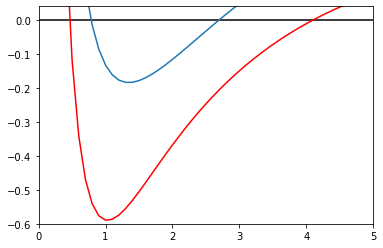

In [232]:
import matplotlib.pyplot as plt
plt.plot(distances, E_list)
plt.plot(distances, E_nuc, color="green")

plt.hlines(0, 0, 5, color="black")
plt.axis([0, 5, -0.6, 0.04])
plt.plot(distances, E_Ulist, color="red")

In [250]:

specifications = f"""
    H 0.0000 0.0000 0.0000
    H 1.0000 0.0000 0.0000
    
    units au
    """

In [251]:
hydrogen = Molecule(specifications)
hydrogen.setGuess()
iterator(hydrogen)

iteration: 0, E_tot: -1.06599946, E_elek: -2.06599946, deltaE: -2.06599946, rmsD:  0.00000000


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-1.0659994621433029

In [252]:
H = hydrogen.displayHamiltonian()

In [253]:
P = hydrogen.getDensityMatrix("alpha") + hydrogen.getDensityMatrix("beta") 

In [254]:
J = np.einsum("nopq,pq->no", hydrogen.displayElectronRepulsion(), P, optimize=True)
K = np.einsum("npoq,pq->no", hydrogen.displayElectronRepulsion(), P, optimize=True)

In [257]:
theta = np.arccos(-np.sqrt((H[1,1] - H[0,0] + J[1,1] - J[0,1] + 2*K[0,1])/(J[0,0] + J[1,1] - 2*J[0,1] + 4*K[0,1])))
theta

2.356194490192345

In [258]:
E = 2*np.cos(theta)**2*H[0,0] + 2*np.sin(theta)**2*H[1,1] + np.cos(theta)**4*J[0,0] + np.sin(theta)**4*J[1,1] + 2*np.sin(theta)**2*np.cos(theta)**2*(J[0,1] - 2*K[0,1])
E

-2.5223482699301996

In [259]:
atom = Molecule("""
H

units au
""")
atom.setGuess()
iterator(atom)

iteration: 0, E_tot: -0.46658185, E_elek: -0.46658185, deltaE: -0.46658185, rmsD:  0.00000000


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-0.46658184955727544

In [129]:
distances = np.arange(0.2, 20, 0.5)
E_list = []
E_nuc = []
E_elek = []
for distance in np.nditer(distances):
    specifications = "Cl 0.0000 0.0000 0.0000" +"\n" f"Cl {distance} 0.0000 0.0000"
    hydrogen = Molecule(specifications)
    hydrogen.setGuess()
    E = iterator(hydrogen)
    E_nuc.append(hydrogen.displayNucRep())
    E_list.append(E)
    E_elek.append(hydrogen.getElectronicEnergy())

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -119.43658688, E_elek: -1564.43658688, deltaE: -1564.43658688, rmsD:  1167.05610887
iteration: 1, E_tot: -126.11671879, E_elek: -1571.11671879, deltaE: -6.68013190, rmsD:  9.12344568
iteration: 2, E_tot: -126.11786968, E_elek: -1571.11786968, deltaE: -0.00115089, rmsD:  0.02248995
iteration: 3, E_tot: -126.11787015, E_elek: -1571.11787015, deltaE: -0.00000047, rmsD:  0.00242802
iteration: 4, E_tot: -126.11787015, E_elek: -1571.11787015, deltaE: -0.00000000, rmsD:  0.00010961
iteration: 5, E_tot: -126.11787015, E_elek: -1571.11787015, deltaE:  0.00000000, rmsD:  0.00000369
iteration: 0, E_tot: -836.09473925, E_elek: -1248.95188210, deltaE: -1248.95188210, rmsD:  406.99638976
iteration: 1, E_tot: -839.05737689, E_elek: -1251.91451975, deltaE: -2.96263764, rmsD:  12.85076392
iteration: 2, E_tot: -839.08147453, E_elek: -1251.93861739, deltaE: -0.02409764, rmsD:  0.78662586
iteration: 3, E_tot: -839.08180671, E_elek: -1251.93894957, deltaE: -0.00033218, rmsD:  0.0150949

iteration: 4, E_tot: -909.10348298, E_elek: -977.91300678, deltaE: -0.00028903, rmsD:  0.02502204
iteration: 5, E_tot: -909.10352363, E_elek: -977.91304744, deltaE: -0.00004065, rmsD:  0.01562436
iteration: 6, E_tot: -909.10353057, E_elek: -977.91305438, deltaE: -0.00000694, rmsD:  0.00777135
iteration: 7, E_tot: -909.10353180, E_elek: -977.91305561, deltaE: -0.00000124, rmsD:  0.00353124
iteration: 8, E_tot: -909.10353202, E_elek: -977.91305583, deltaE: -0.00000022, rmsD:  0.00153366
iteration: 9, E_tot: -909.10353206, E_elek: -977.91305587, deltaE: -0.00000004, rmsD:  0.00064959
iteration: 10, E_tot: -909.10353207, E_elek: -977.91305588, deltaE: -0.00000001, rmsD:  0.00027111
iteration: 11, E_tot: -909.10353207, E_elek: -977.91305588, deltaE: -0.00000000, rmsD:  0.00011215
iteration: 12, E_tot: -909.10353207, E_elek: -977.91305588, deltaE: -0.00000000, rmsD:  0.00004614
iteration: 0, E_tot: -908.13399157, E_elek: -969.62335327, deltaE: -969.62335327, rmsD:  6.99606055
iteration: 1, E

iteration: 18, E_tot: -909.08412796, E_elek: -955.69703119, deltaE: -0.00000006, rmsD:  0.00042381
iteration: 19, E_tot: -909.08412797, E_elek: -955.69703120, deltaE: -0.00000001, rmsD:  0.00014401
iteration: 20, E_tot: -909.08412797, E_elek: -955.69703120, deltaE: -0.00000000, rmsD:  0.00004969
iteration: 0, E_tot: -908.36242421, E_elek: -951.49675257, deltaE: -951.49675257, rmsD:  4.09107813
iteration: 1, E_tot: -908.82783534, E_elek: -951.96216370, deltaE: -0.46541113, rmsD:  0.67629483
iteration: 2, E_tot: -908.84781255, E_elek: -951.98214090, deltaE: -0.01997720, rmsD:  0.09100107
iteration: 3, E_tot: -908.84919993, E_elek: -951.98352828, deltaE: -0.00138738, rmsD:  0.00816566
iteration: 4, E_tot: -908.84934675, E_elek: -951.98367510, deltaE: -0.00014682, rmsD:  0.01624367
iteration: 5, E_tot: -908.84937193, E_elek: -951.98370029, deltaE: -0.00002518, rmsD:  0.01045711
iteration: 6, E_tot: -908.84937719, E_elek: -951.98370555, deltaE: -0.00000526, rmsD:  0.00549402
iteration: 7, E

iteration: 1, E_tot: -908.84203688, E_elek: -942.06042768, deltaE: -0.35515683, rmsD:  0.50036855
iteration: 2, E_tot: -908.85364963, E_elek: -942.07204043, deltaE: -0.01161275, rmsD:  0.05959929
iteration: 3, E_tot: -908.85438336, E_elek: -942.07277416, deltaE: -0.00073373, rmsD:  0.01012504
iteration: 4, E_tot: -908.85445887, E_elek: -942.07284967, deltaE: -0.00007551, rmsD:  0.01294759
iteration: 5, E_tot: -908.85447136, E_elek: -942.07286217, deltaE: -0.00001249, rmsD:  0.00773854
iteration: 6, E_tot: -908.85447380, E_elek: -942.07286460, deltaE: -0.00000243, rmsD:  0.00655176
iteration: 7, E_tot: -908.85447719, E_elek: -942.07286800, deltaE: -0.00000339, rmsD:  0.05057091
iteration: 8, E_tot: -908.85531264, E_elek: -942.07370344, deltaE: -0.00083545, rmsD:  0.91825105
iteration: 9, E_tot: -908.94558839, E_elek: -942.16397919, deltaE: -0.09027575, rmsD:  2.07798583
iteration: 10, E_tot: -909.07699032, E_elek: -942.29538112, deltaE: -0.13140193, rmsD:  0.37039492
iteration: 11, E_to

iteration: 5, E_tot: -908.84230780, E_elek: -934.64587923, deltaE: -0.00008303, rmsD:  0.42130094
iteration: 6, E_tot: -908.88445779, E_elek: -934.68802921, deltaE: -0.04214999, rmsD:  2.60712296
iteration: 7, E_tot: -909.07712649, E_elek: -934.88069792, deltaE: -0.19266870, rmsD:  0.36903198
iteration: 8, E_tot: -909.08414148, E_elek: -934.88771291, deltaE: -0.00701500, rmsD:  0.05596153
iteration: 9, E_tot: -909.08432135, E_elek: -934.88789277, deltaE: -0.00017986, rmsD:  0.00919836
iteration: 10, E_tot: -909.08432596, E_elek: -934.88789738, deltaE: -0.00000461, rmsD:  0.00159647
iteration: 11, E_tot: -909.08432608, E_elek: -934.88789751, deltaE: -0.00000012, rmsD:  0.00030645
iteration: 12, E_tot: -909.08432608, E_elek: -934.88789751, deltaE: -0.00000000, rmsD:  0.00007017
iteration: 13, E_tot: -909.08432608, E_elek: -934.88789751, deltaE: -0.00000000, rmsD:  0.00002003
iteration: 0, E_tot: -908.60042097, E_elek: -933.30127567, deltaE: -933.30127567, rmsD:  2.18867299
iteration: 1, 

iteration: 4, E_tot: -909.08416882, E_elek: -928.74403277, deltaE: -0.01347300, rmsD:  0.05996448
iteration: 5, E_tot: -909.08436645, E_elek: -928.74423039, deltaE: -0.00019763, rmsD:  0.00746228
iteration: 6, E_tot: -909.08436972, E_elek: -928.74423366, deltaE: -0.00000327, rmsD:  0.00102542
iteration: 7, E_tot: -909.08436984, E_elek: -928.74423378, deltaE: -0.00000012, rmsD:  0.00017656
iteration: 8, E_tot: -909.08436985, E_elek: -928.74423380, deltaE: -0.00000001, rmsD:  0.00004369
iteration: 9, E_tot: -909.08436985, E_elek: -928.74423380, deltaE: -0.00000000, rmsD:  0.00001476
iteration: 10, E_tot: -909.08436985, E_elek: -928.74423380, deltaE: -0.00000000, rmsD:  0.00000580
iteration: 0, E_tot: -908.64659061, E_elek: -927.65974850, deltaE: -927.65974850, rmsD:  1.48576133
iteration: 1, E_tot: -908.82799826, E_elek: -927.84115615, deltaE: -0.18140765, rmsD:  0.63767064
iteration: 2, E_tot: -908.88750261, E_elek: -927.90066051, deltaE: -0.05950435, rmsD:  2.69557638
iteration: 3, E_t

iteration: 0, E_tot: -908.39653646, E_elek: -923.85108192, deltaE: -923.85108192, rmsD:  4.39388041
iteration: 1, E_tot: -909.08271821, E_elek: -924.53726367, deltaE: -0.68618175, rmsD:  0.00000322
iteration: 2, E_tot: -909.08418523, E_elek: -924.53873069, deltaE: -0.00146702, rmsD:  0.00000025
iteration: 3, E_tot: -909.08435271, E_elek: -924.53889817, deltaE: -0.00016748, rmsD:  0.00000001
iteration: 4, E_tot: -909.08438127, E_elek: -924.53892673, deltaE: -0.00002856, rmsD:  0.00000000
iteration: 5, E_tot: -909.08438625, E_elek: -924.53893170, deltaE: -0.00000497, rmsD:  0.00000000
iteration: 6, E_tot: -909.08438711, E_elek: -924.53893257, deltaE: -0.00000087, rmsD:  0.00000000
iteration: 7, E_tot: -909.08438726, E_elek: -924.53893272, deltaE: -0.00000015, rmsD:  0.00000000
iteration: 8, E_tot: -909.08438729, E_elek: -924.53893275, deltaE: -0.00000003, rmsD:  0.00000000
iteration: 9, E_tot: -909.08438730, E_elek: -924.53893275, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 10, E_t

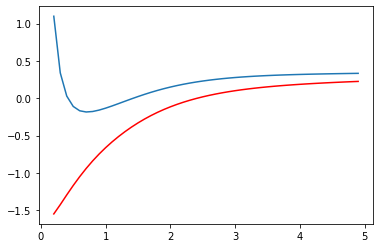

In [36]:
import matplotlib.pyplot as plt
plt.plot(distances, E_list)
plt.plot(distances, E_elek, color="red")

In [145]:
E_list

[-126.11787014962852,
 -839.0818123840293,
 -892.3204141972739,
 -902.9619200785287,
 -906.9802214304929,
 -908.4772130007149,
 -908.978224318583,
 -909.1078788237857,
 -909.103532067438,
 -909.0573609659988,
 -909.0870044084412,
 -909.0848895765262,
 -909.0841279712454,
 -909.083933693559,
 -909.0839539773949,
 -909.0840337404597,
 -909.0841142398428,
 -909.084179318444,
 -909.084228264219,
 -909.0842643695248,
 -909.0842910636476,
 -909.0843110032102,
 -909.0843260813427,
 -909.0843376220416,
 -909.0843465555743,
 -909.084353543635,
 -909.0843590626747,
 -909.0843634604234,
 -909.0843669939395,
 -909.0843698548227,
 -909.0843721878464,
 -909.0843741031406,
 -909.084375685394,
 -909.0843770002825,
 -909.0843780988654,
 -909.0843880172145,
 -909.0843876270307,
 -909.0843872961796,
 -909.084384035771,
 -909.0843845772878]

In [102]:
psi4.set_options({'basis': '6-31G*'})
oxygen = Molecule("""pubchem:oxygen""")
oxygen.setGuess()
iterator(oxygen)

	Searching PubChem database for oxygen (single best match returned)
	Found 1 result(s)


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -140.63821919, E_elek: -168.12794442, deltaE: -168.12794442, rmsD:  44.10307070
iteration: 1, E_tot: -148.49434055, E_elek: -175.98406578, deltaE: -7.85612137, rmsD:  12.61808497
iteration: 2, E_tot: -149.25358156, E_elek: -176.74330679, deltaE: -0.75924101, rmsD:  3.41584212
iteration: 3, E_tot: -149.32437379, E_elek: -176.81409902, deltaE: -0.07079223, rmsD:  1.09873535
iteration: 4, E_tot: -149.33249922, E_elek: -176.82222445, deltaE: -0.00812543, rmsD:  0.37328518
iteration: 5, E_tot: -149.33355145, E_elek: -176.82327668, deltaE: -0.00105223, rmsD:  0.13317695
iteration: 6, E_tot: -149.33370713, E_elek: -176.82343236, deltaE: -0.00015568, rmsD:  0.05338514
iteration: 7, E_tot: -149.33373314, E_elek: -176.82345837, deltaE: -0.00002601, rmsD:  0.02281619
iteration: 8, E_tot: -149.33373791, E_elek: -176.82346314, deltaE: -0.00000477, rmsD:  0.00994806
iteration: 9, E_tot: -149.33373883, E_elek: -176.82346406, deltaE: -0.00000093, rmsD:  0.00438698
iteration: 10, E

-149.33373906923083